In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.stats import pearsonr
from scipy.sparse import linalg
from scipy.linalg import solve, pinv
import matplotlib.pyplot as plt

In [2]:
def dxdt_lorenz(x,time,r_t, sigma = 10., beta = 8/3, rho = 28.):
    return np.array([sigma*(- x[0] + x[1]),\
                     r_t(time)*rho*x[0] - x[1] - x[0]*x[2],\
                     x[0]*x[1]-beta*x[2]])
    
def rk4(x, time, tau, r_t, dxdt):
    k1 = dxdt(x, time, r_t)
    k2 = dxdt(x + k1/2*tau, time + tau/2, r_t)
    k3 = dxdt(x + k2/2*tau, time + tau/2, r_t)
    k4 = dxdt(x + tau*k3, time + tau, r_t)
    
    xnext = x + 1/6*tau*(k1+2*k2+2*k3+k4)
    return xnext

def getLorenzData(data_length, r_t, dxdt_lorenz,transient_length = 1000, tau = 0.1):
    x = np.random.rand(3)
    time = -transient_length*tau
    for i in range(0,transient_length):
        x = rk4(x,time,tau,r_t,dxdt_lorenz)
        time += tau
    
    data = np.zeros((3,data_length))
    data[:,0] = x
    for i in range(0,data_length-1):
        data[:,i+1] = rk4(data[:,i],time,tau,r_t,dxdt_lorenz)
        time += tau
        
    return data

def r_t_cosine(time, period = 500, max_height = 48/28):
    r = 1 + (max_height-1.)/2 - (max_height-1)/2*np.cos(2*np.pi/period*time)
    return r

def r_t_const(time, value = 1.):
    # Function for constant rho value
    r = value
    return r

def advanceReservoir(win,A_mat,x,u,leakage):
    x_next = leakage*x + (1-leakage)*np.tanh(A_mat.dot(x) + np.matmul(win,u))
    return x_next

def getPrediction(win, A_mat, wout, x, predict_length, leakage):
    prediction = np.zeros((wout.shape[0],predict_length))
    aug_x = np.copy(x)
    aug_x[::2] = np.power(x[::2],2)
    prediction[:,0] = np.matmul(wout,aug_x)
    
    for pred_idx in range(0,predict_length - 1):
        x = advanceReservoir(win, A_mat, x, prediction[:,pred_idx], leakage)
        aug_x = np.copy(x)
        aug_x[::2] = np.power(x[::2],2)
        prediction[:,pred_idx + 1] = np.matmul(wout,aug_x)
        
    return prediction

def getPredictionLineart(win, A_mat, wout, x, predict_length, leakage, step):
    prediction = np.zeros((wout.shape[0],predict_length))
    time = 0
    num_nodes = x.shape[0]
    aug_x = np.zeros(2*num_nodes)
    aug_x[:num_nodes] = x
    aug_x[num_nodes:] = x
    aug_x[::2] = np.power(aug_x[::2],2)
    aug_x[num_nodes:] = aug_x[num_nodes:]*time
    prediction[:,0] = np.matmul(wout,aug_x)
    
    for pred_idx in range(0,predict_length - 1):
        time += step
        x = advanceReservoir(win, A_mat, x, prediction[:,pred_idx], leakage)
        aug_x[:num_nodes] = x
        aug_x[num_nodes:] = x
        aug_x[::2] = np.power(aug_x[::2],2)
        aug_x[num_nodes:] = time * aug_x[num_nodes:]
        prediction[:,pred_idx + 1] = np.matmul(wout,aug_x)
        
    return prediction

def evaluatePrediction(win, A_mat, wout, x, predict_length, leakage, truth, error_cutoff, true_var):
    prediction = getPrediction(win,A_mat,wout,x,predict_length,leakage)
                    
    error = np.linalg.norm(prediction - truth, axis = 0)/true_var
    valid_time = 0.
    for i in range(predict_length):
        if error[i] > error_cutoff:
            break
        else:
            valid_time += 1
            
    return prediction, error, valid_time

def evaluatePredictionLineart(win, A_mat, wout, x, predict_length, leakage, truth, error_cutoff,step):
    prediction = getPredictionLineart(win,A_mat,wout,x,predict_length,leakage,step)
                    
    error = np.linalg.norm(prediction - truth, axis = 0)/np.sqrt(np.mean(truth**2))
    valid_time = 0.
    for i in range(predict_length):
        if error[i] > error_cutoff:
            break
        else:
            valid_time += 1
            
    return prediction, error, valid_time

def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
        
    return freq

In [3]:
input_weight = 1e-2
spectral_radius = 0.9
average_degree = 3
leakage = 0
forgets = np.array([0.999,0.99,0.985,0.98])
regularization_base = 1e-9
regularization = regularization_base/(1-forgets)
regularization_wt = regularization_base/((1-forgets)**3)
print(regularization_wt)
# forgets = np.array([1.])
# regularization = np.array([1e-6])
# print(regularization)
# forgets = np.array([0.9825])
inv_forgets = 1/forgets
# print(inv_forgets)
data_seed = 30
cumulative = False
w_LM_reg = True
approx_LM_reg = True
LM_regs = np.array([1e-10])

step = 0.05
transient_length = int(50/step)
data_length = int(3000/step)
train_length = int(500/step)
start_length = int(50/step)
predict_length = int(20/step)
predict_gap_length = int(2/step)
num_predictions = 250
num_trials = 100
num_forgets = forgets.shape[0]
approx_num_nodes = 300

[1.00000000e+00 1.00000000e-03 2.96296296e-04 1.25000000e-04]


In [4]:
np.random.seed(data_seed)
train_input_sequence = getLorenzData(data_length,r_t_cosine,dxdt_lorenz,tau = 0.05)

input_size = train_input_sequence.shape[0]
num_nodes = int(np.ceil(approx_num_nodes/input_size)*input_size);

A_mat = sparse.random(num_nodes,num_nodes, density = average_degree/num_nodes)
eg = linalg.eigs(A_mat, k = 1, return_eigenvectors=False)
A_mat = spectral_radius/np.abs(eg[0])*A_mat

q = int(np.floor(num_nodes/(input_size)))
win = np.zeros((num_nodes,input_size))
for i in range(input_size):
    np.random.seed(i)
    ip = (-1 + 2*np.random.randn(q));
    win[i*q:(i+1)*q,i] = input_weight*ip;

In [20]:
predictions = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
truths = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
errors = np.zeros((predict_length,num_predictions,num_trials,num_forgets))
valid_times = np.zeros((num_predictions,num_trials,num_forgets))

# predictions_exactinv = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
# errors_exactinv = np.zeros((predict_length,num_predictions,num_trials,num_forgets))
# valid_times_exactinv = np.zeros((num_predictions,num_trials,num_forgets))

delta = 1.
for data_seed in range(num_trials):
    np.random.seed(data_seed)
    train_input_sequence = getLorenzData(data_length,r_t_cosine,dxdt_lorenz,tau = 0.05)
    for k in range(num_forgets):
        for LM_reg in LM_regs:
            times = np.zeros(num_predictions)

            x = np.zeros(num_nodes)
            # states = np.zeros((num_nodes, start_length))

            for t in range(transient_length-1):
                x = advanceReservoir(win,A_mat,x,train_input_sequence[:,t],leakage)
            data_trstates = np.zeros((input_size,num_nodes))
            states_trstates_inv = delta*np.identity(num_nodes)
            # states_trstates_inv_exactinv = delta*np.identity(num_nodes)
            error_cutoff = 1;
            if w_LM_reg:
                LM_idenmat = sparse.identity(num_nodes)
            for pred in range(num_predictions):
                start_pred_idx = transient_length + pred*predict_gap_length - 1
                times[pred] = start_pred_idx*step
                for i in range(predict_gap_length):
                    x = advanceReservoir(win,A_mat,x,train_input_sequence[:,start_pred_idx + i],leakage)
                    aug_x = np.copy(x)
                    aug_x[::2] = np.power(x[::2],2)
                    data_trstates = forgets[k]*data_trstates + \
                        np.outer(train_input_sequence[:,start_pred_idx + i + 1],aug_x)
                    states_trstates_inv = inv_forgets[k]*(states_trstates_inv - 1.0/\
                            (1+inv_forgets[k]*np.dot(np.dot(aug_x,states_trstates_inv),aug_x))*\
                            np.outer(np.dot(states_trstates_inv,aug_x),np.dot(aug_x,states_trstates_inv))\
                            *inv_forgets[k])
                    # states_trstates_inv_exactinv = inv_forgets[k]*(states_trstates_inv_exactinv - 1.0/\
                            # (1+inv_forgets[k]*np.dot(np.dot(aug_x,states_trstates_inv_exactinv),aug_x))*\
                            # np.outer(np.dot(states_trstates_inv_exactinv,aug_x),np.dot(aug_x,states_trstates_inv_exactinv))\
                            # *inv_forgets[k])
                    states_trstates_inv = states_trstates_inv - \
                        LM_reg*np.matmul(states_trstates_inv,states_trstates_inv)
                    # states_trstates_inv_exactinv = np.transpose(solve(np.transpose(LM_reg*states_trstates_inv_exactinv + \
                        # LM_idenmat),np.transpose(states_trstates_inv_exactinv)))
                wout = np.matmul(data_trstates,states_trstates_inv)

                # wout_exactinv = np.matmul(data_trstates,states_trstates_inv_exactinv)
                # if pred == num_predictions - 1:
                    # print(np.linalg.norm(wout-wout_exactinv))
                
                
                truths[:,:,pred,data_seed,k] = train_input_sequence[:,start_pred_idx + predict_gap_length:start_pred_idx +predict_gap_length + predict_length]
                predictions[:,:,pred,data_seed,k], errors[:,pred,data_seed,k], valid_times[pred,data_seed,k] =\
                    evaluatePrediction(win, A_mat, wout, x, predict_length, leakage, truths[:,:,pred,data_seed,k], error_cutoff)
                # predictions_exactinv[:,:,pred,data_seed,k], errors_exactinv[:,pred,data_seed,k], valid_times_exactinv[pred,data_seed,k] =\
                    # evaluatePrediction(win, A_mat, wout_exactinv, x, predict_length, leakage, truths[:,:,pred,data_seed,k], error_cutoff)



                
                # np.savetxt('Lorenz63Data/lorenz_prediction_lam%f_reg%f_seed%d_pred%d.csv' % (forgets[k],LM_reg,data_seed,pred),prediction,delimiter = ',')
                # np.savetxt('Lorenz63Data/lorenz_error_lam%f_reg%f_seed%d_pred%d.csv' % (forgets[k],LM_reg,data_seed,pred),error,delimiter = ',')
                # if k == 0 and LM_reg == LM_regs[0]:
                    # np.savetxt('Lorenz63Data/lorenz_truth_seed%d_pred%d.csv' % (data_seed,pred),truth,delimiter = ',')
            print(data_seed, k, LM_reg)
            #np.savetxt('Lorenz63Data/lorenz_valid_times_period500_winnergarbage_lam%f_reg%e_seed%d.csv' % (forgets[k],LM_reg,data_seed),valid_times[:,data_seed,k],delimiter = ',')
for i in range(num_forgets):
    valid_time_save = valid_times[:,:,i]
    np.savetxt('Lorenz63Data/lorenz_valid_times_rperiod500_lam%f_reg%e_delta%e.csv' % (forgets[i],LM_reg,delta),valid_time_save,delimiter = ',')

KeyboardInterrupt: 

In [53]:
predictions_norm = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
truths_norm = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
errors_norm = np.zeros((predict_length,num_predictions,num_trials,num_forgets))
valid_times_norm = np.zeros((num_predictions,num_trials,num_forgets))
ic_errors_norm = np.zeros((num_predictions,num_trials,num_forgets))
for data_seed in range(num_trials):
    np.random.seed(data_seed)
    train_input_sequence = getLorenzData(data_length,r_t_const,dxdt_lorenz,tau = 0.05)
    true_var = np.sqrt(np.mean(train_input_sequence**2))
    for k in range(num_forgets):
        times = np.zeros(num_predictions)

        x = np.zeros(num_nodes)
        # states = np.zeros((num_nodes, start_length))

        for t in range(transient_length-1):
            x = advanceReservoir(win,A_mat,x,train_input_sequence[:,t],leakage)

        error_cutoff = 0.2;
        aug_states = np.zeros((num_nodes,predict_gap_length*num_predictions))

        for pred in range(num_predictions):
            start_pred_idx = transient_length + pred*predict_gap_length-1
            times[pred] = start_pred_idx*step
            for i in range(predict_gap_length):
                x = advanceReservoir(win,A_mat,x,train_input_sequence[:,start_pred_idx + i],leakage)
                aug_x = np.copy(x)
                aug_x[::2] = np.power(x[::2],2)
                aug_states[:,i + pred*predict_gap_length] = aug_x
            s_mat = sparse.diags(np.power(forgets[k],np.arange((pred+1)*predict_gap_length)[::-1]))
            data_trstates_norm = train_input_sequence[:,transient_length:transient_length+(pred+1)*predict_gap_length] @ \
                      s_mat @ aug_states[:,:(pred+1)*predict_gap_length].T
            states_trstates_norm = aug_states[:,:(pred+1)*predict_gap_length] @ s_mat @ aug_states[:,:(pred+1)*predict_gap_length].T\
                      + regularization[k]*sparse.identity(num_nodes)
            wout_norm = np.transpose(solve(states_trstates_norm.T,data_trstates_norm.T))
            

        # train_pred = wout_norm @ aug_states[:,:(pred+1)*predict_gap_length]
        # truth = train_input_sequence[:,transient_length:transient_length+(pred+1)*predict_gap_length]
        # train_errors_norm[:,data_seed,k] = np.linalg.norm(train_pred - truth, axis = 0)/np.sqrt(np.mean(truth**2))
            truths_norm[:,:,pred,data_seed,k] = train_input_sequence[:,start_pred_idx + predict_gap_length:start_pred_idx + predict_gap_length + predict_length]
            predictions_norm[:,:,pred,data_seed,k], errors_norm[:,pred,data_seed,k], valid_times_norm[pred,data_seed,k] =\
                evaluatePrediction(win, A_mat, wout_norm, x, predict_length, leakage, truths_norm[:,:,pred,data_seed,k], error_cutoff, true_var)
            ic_errors_norm[pred,data_seed,k] = errors_norm[0,pred,data_seed,k]
        print(k, data_seed)
for i in range(num_forgets):
    valid_time_save = valid_times_norm[:,:,i]
    np.savetxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_tikreg%e_step%f.csv' % (forgets[i],regularization[i],step),valid_time_save,delimiter = ',')
    for j in range(num_trials):
        error_save = errors_norm[:,:,j,i]
        np.savetxt('Lorenz63Data/lorenz_error_constr_lam%f_tikreg%e_trial%d_step%f.csv' % (forgets[i],regularization[i],j,step), error_save)

0 0
1 0
0 1
1 1
0 2
1 2
0 3
1 3
0 4
1 4
0 5
1 5
0 6
1 6
0 7
1 7
0 8
1 8
0 9
1 9
0 10
1 10
0 11
1 11
0 12
1 12
0 13
1 13
0 14
1 14
0 15
1 15
0 16
1 16
0 17
1 17
0 18
1 18
0 19
1 19
0 20
1 20
0 21
1 21
0 22
1 22
0 23
1 23
0 24
1 24
0 25
1 25
0 26
1 26
0 27
1 27
0 28
1 28
0 29
1 29
0 30
1 30
0 31
1 31
0 32
1 32
0 33
1 33
0 34
1 34
0 35
1 35
0 36
1 36
0 37
1 37
0 38
1 38
0 39
1 39
0 40
1 40
0 41
1 41
0 42
1 42
0 43
1 43
0 44
1 44
0 45
1 45
0 46
1 46
0 47
1 47
0 48
1 48
0 49
1 49
0 50
1 50
0 51
1 51
0 52
1 52
0 53
1 53
0 54
1 54
0 55
1 55
0 56
1 56
0 57
1 57
0 58
1 58
0 59
1 59
0 60
1 60
0 61
1 61
0 62
1 62
0 63
1 63
0 64
1 64
0 65
1 65
0 66
1 66
0 67
1 67
0 68
1 68
0 69
1 69
0 70
1 70
0 71
1 71
0 72
1 72
0 73
1 73
0 74
1 74
0 75
1 75
0 76
1 76
0 77
1 77
0 78
1 78
0 79
1 79
0 80
1 80
0 81
1 81
0 82
1 82
0 83
1 83
0 84
1 84
0 85
1 85
0 86
1 86
0 87
1 87
0 88
1 88
0 89
1 89
0 90
1 90
0 91
1 91
0 92
1 92
0 93
1 93
0 94
1 94
0 95
1 95
0 96
1 96
0 97
1 97
0 98
1 98
0 99
1 99


In [20]:
avg_errors = np.mean(errors_norm, axis = 2)

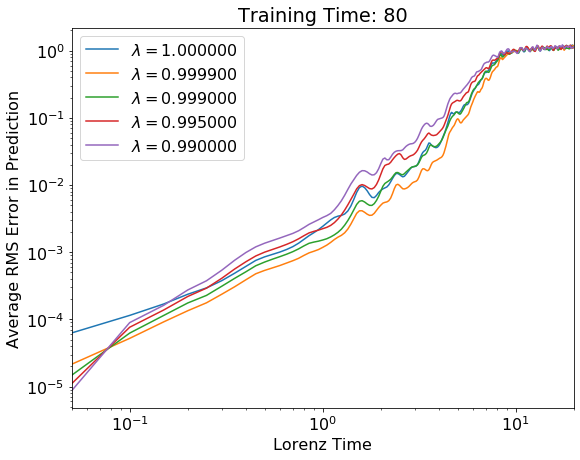

In [42]:
plot_pred = 40
plt.figure(figsize = (9,7))
for i in range(avg_errors.shape[2]):
    plt_lambda = forgets[i]
    plt.plot(step*np.arange(avg_errors.shape[0])+step,avg_errors[:,plot_pred,i],label = '$\lambda = %f$' % plt_lambda)
plt.xlabel('Lorenz Time')
plt.ylabel('Average RMS Error in Prediction')
plt.title('Training Time: %d' % (plot_pred*predict_gap_length*step) )
plt.yscale('log')
plt.xscale('log')
plt.rc('font',size = 16)
plt.xlim(step,20)
plt.legend()
plt.show()

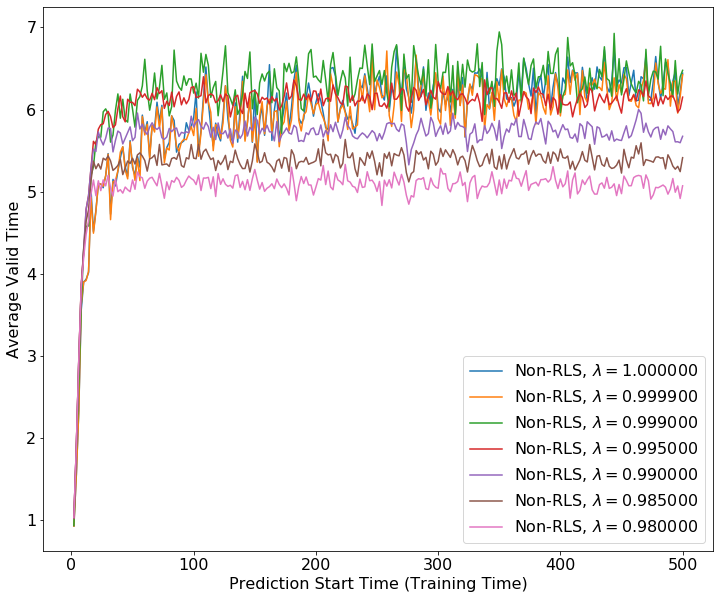

In [38]:
plot_times = (np.arange(num_predictions)+1)*predict_gap_length*step
forgets = np.array([1.0,0.9999,0.999,0.995,0.99,0.985,0.98])
num_forgets = len(forgets)
regularization = np.append(1e-6,1e-10/(1-forgets[1:]))
valid_times_plot = np.zeros((num_predictions,num_forgets))
plt.figure(figsize = (12,10))
for i in range(num_forgets):
    plt_lambda = forgets[i]
    temp_valid_times = np.loadtxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_tikreg%e_step%f.csv' % (forgets[i],regularization[i],step),delimiter = ',')
    valid_times_plot[:,i] = np.mean(temp_valid_times, axis = 1)
    plt.plot(plot_times,valid_times_plot[:,i]*step,label = 'Non-RLS, $\lambda = %f$' % plt_lambda)
plt.xlabel('Prediction Start Time (Training Time)')
plt.ylabel('Average Valid Time')
plt.legend()
plt.show()

In [10]:
for i in range(num_forgets):
    valid_time_save = valid_times_norm[:,:,i]
    np.savetxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_tikreg%e.csv' % (forgets[i],regularization[i]),valid_time_save,delimiter = ',')
    for j in range(num_trials):
        error_save = errors_norm[:,:,j,i]
        np.savetxt('Lorenz63Data/lorenz_error_constr_lam%f_tikreg%e_trial%d.csv' % (forgets[i],regularization[i],j), error_save)

In [ ]:
predictions_norm_wt = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
truths_norm_wt = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
errors_norm_wt = np.zeros((predict_length,num_predictions,num_trials,num_forgets))
valid_times_norm_wt = np.zeros((num_predictions,num_trials,num_forgets))
ic_error_norm_wt = np.zeros((num_predictions,num_trials,num_forgets))
for data_seed in range(num_trials):
    np.random.seed(data_seed)
    train_input_sequence = getLorenzData(data_length,r_t_cosine,dxdt_lorenz,tau = 0.05)
    for k in range(num_forgets):
        times = np.zeros(num_predictions)

        x = np.zeros(num_nodes)
        # states = np.zeros((num_nodes, start_length))

        for t in range(transient_length-1):
            x = advanceReservoir(win,A_mat,x,train_input_sequence[:,t],leakage)

        error_cutoff = 1;
        aug_states = np.zeros((num_nodes,predict_gap_length*num_predictions))
        regularization_mat = sparse.identity(2*num_nodes)
        regularization_mat.data[0,:num_nodes] = regularization[k]*regularization_mat.data[0,:num_nodes]
        regularization_mat.data[0,num_nodes:] = regularization_wt[k]*regularization_mat.data[0,num_nodes:]
        for pred in range(num_predictions):
            start_pred_idx = transient_length + pred*predict_gap_length-1
            times[pred] = start_pred_idx*step
            for i in range(predict_gap_length):
                x = advanceReservoir(win,A_mat,x,train_input_sequence[:,start_pred_idx + i],leakage)
                aug_x = np.copy(x)
                aug_x[::2] = np.power(x[::2],2)
                aug_states[:,i + pred*predict_gap_length] = aug_x
            aug_states_wt = np.zeros((2*num_nodes,predict_gap_length*(pred+1)))
            t_scale_mat = sparse.diags(np.arange((1-aug_states[:,:(pred+1)*predict_gap_length].shape[1])*step,step,step))
            if np.abs(t_scale_mat.data[0][-1] - step) < 1e-6:
                t_scale_mat = sparse.diags(np.arange((1-aug_states[:,:(pred+1)*predict_gap_length].shape[1])*step,1e-6,step))
            aug_states_wt[:num_nodes,:] = aug_states[:,:(pred+1)*predict_gap_length]
            aug_states_wt[num_nodes:,:] = aug_states[:,:(pred+1)*predict_gap_length] @ t_scale_mat
            # print(aug_states_wt.shape)
            # print(t_scale_mat.shape)
            s_mat = sparse.diags(np.power(forgets[k],np.arange((pred+1)*predict_gap_length)[::-1]))
            data_trstates_norm = train_input_sequence[:,transient_length:transient_length+(pred+1)*predict_gap_length] @ \
                      s_mat @ aug_states_wt[:,:(pred+1)*predict_gap_length].T
            states_trstates_norm = aug_states_wt[:,:(pred+1)*predict_gap_length] @ s_mat @ aug_states_wt[:,:(pred+1)*predict_gap_length].T\
                      + regularization_mat
            """
            if pred > 400:
                info_norm = np.linalg.norm(aug_states_wt[:num_nodes,:(pred+1)*predict_gap_length] @ s_mat @ \
                                          aug_states_wt[:num_nodes,:(pred+1)*predict_gap_length].T)
                info_norm_wt = np.linalg.norm(aug_states_wt[num_nodes:,:(pred+1)*predict_gap_length] @ s_mat @ \
                                          aug_states_wt[num_nodes:,:(pred+1)*predict_gap_length].T)
                print('Info norm/info norm wt: %f' % (info_norm/info_norm_wt))
            """
            wout_norm_wt = np.transpose(solve(states_trstates_norm.T,data_trstates_norm.T))

            truths_norm_wt[:,:,pred,data_seed,k] = train_input_sequence[:,start_pred_idx + predict_gap_length:start_pred_idx + predict_gap_length + predict_length]
            predictions_norm_wt[:,:,pred,data_seed,k], errors_norm_wt[:,pred,data_seed,k], valid_times_norm_wt[pred,data_seed,k] =\
                evaluatePredictionLineart(win, A_mat, wout_norm_wt, x, predict_length, leakage, truths_norm_wt[:,:,pred,data_seed,k], error_cutoff,step)
            ic_error_norm_wt[pred,data_seed,k] = errors_norm_wt[0,pred,data_seed,k]
        print(k, data_seed)

0 0
1 0
2 0
3 0
0 1
1 1
2 1
3 1
0 2
1 2
2 2
3 2
0 3
1 3
2 3
3 3
0 4
1 4
2 4
3 4
0 5
1 5
2 5
3 5
0 6
1 6
2 6
3 6
0 7
1 7
2 7
3 7
0 8
1 8
2 8
3 8
0 9


In [ ]:
for i in range(num_forgets):
    valid_time_save = valid_times_norm_wt[:,:,i]
    np.savetxt('Lorenz63Data/lorenz_valid_times_wt_rperiod500_lam%f_tikreg_norm%e_wt%e_step%f.csv' % (forgets[i],regularization[i],regularization_wt[i],step),valid_time_save,delimiter = ',')
    for j in range(num_trials):
        error_save = errors_norm_wt[:,:,j,i]
        np.savetxt('Lorenz63Data/lorenz_error_wt_rperiod500_lam%f_tikreg_norm%e_wt%e_trial%d_step%f.csv' % (forgets[i],regularization[i],regularization_wt[i],j,step), error_save,delimiter = ',')

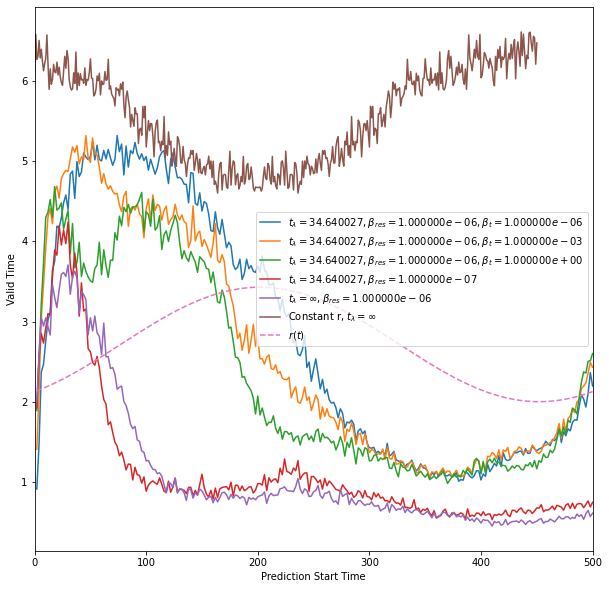

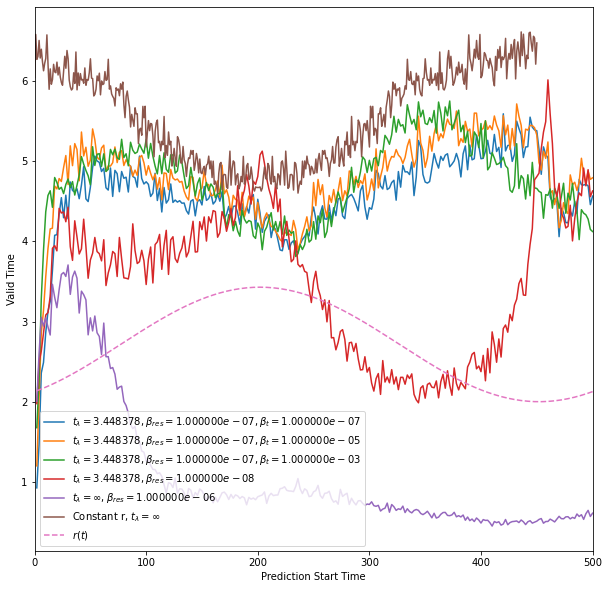

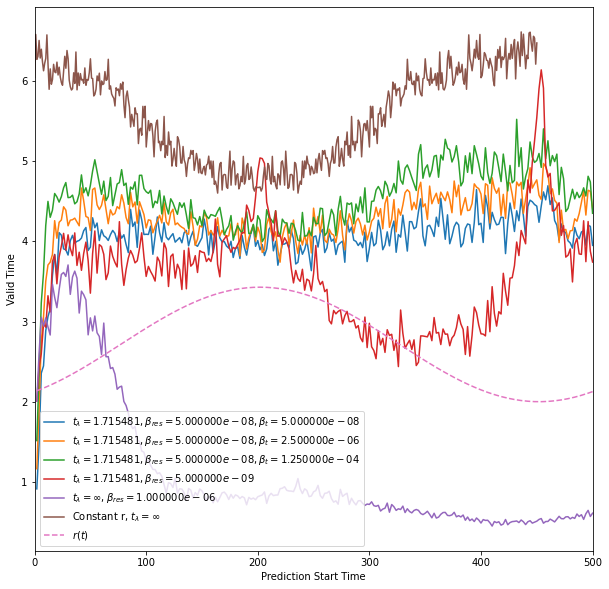

In [9]:
regularization_plot = regularization_base/(1-forgets)
regularization_plot_norm = 1e-10/(1-forgets)
regularization_plot_wt = regularization_base/((1-forgets))
regularization_plot_wt2 = regularization_base/((1-forgets)**2)
regularization_plot_wt3 = regularization_base/((1-forgets)**3)
times = step*(transient_length + np.arange(num_predictions)*predict_gap_length - 1)
valid_time_noforget = np.loadtxt('Lorenz63Data/lorenz_valid_times_rperiod500_lam1.000000_tikreg1.000000e-06.csv',delimiter = ',')
rvals = r_t_cosine(np.arange(250))
constr_valid_times = np.zeros((250,100))
for i in range(250):
    constr_valid_times[i] = np.loadtxt('Lorenz63Data/lorenz_valid_times_constr%f_lam%f_tikreg%e_step%f.csv' % (rvals[i],1.,1e-6,step),delimiter = ',')
    
avg_constr_valid_times = np.mean(constr_valid_times,axis = 1)
avg_constr_valid_times = np.append(avg_constr_valid_times,avg_constr_valid_times[-1])
avg_constr_valid_times = np.append(avg_constr_valid_times,avg_constr_valid_times[249::-1])

for k in [0,1,3]:
    plt.figure(figsize=(10, 10))
    tlfg = step*np.log(1/2)/np.log(forgets[k]) 
    valid_time_wt_1 = np.loadtxt('Lorenz63Data/lorenz_valid_times_wt_rperiod500_lam%f_tikreg_norm%e_wt%e_step%f.csv' % (forgets[k],regularization_plot[k],regularization_plot_wt[k], step), delimiter = ',')
    valid_time_wt_2 = np.loadtxt('Lorenz63Data/lorenz_valid_times_wt_rperiod500_lam%f_tikreg_norm%e_wt%e_step%f.csv' % (forgets[k],regularization_plot[k],regularization_plot_wt2[k], step), delimiter = ',')
    valid_time_norm = np.loadtxt('Lorenz63Data/lorenz_valid_times_rperiod500_lam%f_tikreg%e.csv' % (forgets[k],regularization_plot_norm[k]), delimiter = ',')
    valid_time_wt_3 = np.loadtxt('Lorenz63Data/lorenz_valid_times_wt_rperiod500_lam%f_tikreg_norm%e_wt%e_step%f.csv' % (forgets[k],regularization_plot[k],regularization_plot_wt3[k], step), delimiter = ',')
    plt.plot(times-times[0]+predict_gap_length*step,np.mean(valid_time_wt_1,axis = 1)*step,label = r'$t_\lambda = %f, \beta_{res} = %e, \beta_t = %e$' % \
             (tlfg, regularization_plot[k], regularization_plot_wt[k]))
    plt.plot(times-times[0]+predict_gap_length*step,np.mean(valid_time_wt_2,axis = 1)*step,label = r'$t_\lambda = %f, \beta_{res} = %e, \beta_t = %e$' % \
             (tlfg, regularization_plot[k], regularization_plot_wt2[k]))
    plt.plot(times-times[0]+predict_gap_length*step,np.mean(valid_time_wt_3,axis = 1)*step,label = r'$t_\lambda = %f, \beta_{res} = %e, \beta_t = %e$' % \
             (tlfg, regularization_plot[k], regularization_plot_wt3[k]))
    plt.plot(times-times[0]+predict_gap_length*step,np.mean(valid_time_norm,axis = 1)*step,label = r'$t_\lambda = %f, \beta_{res} = %e$' % \
             (tlfg, regularization_plot_norm[k]))
    plt.plot(times-times[0]+predict_gap_length*step,np.mean(valid_time_noforget,axis = 1)*step,label = r'$t_\lambda = \infty, \beta_{res} = %e$' % \
             (1e-6))
    plt.plot(np.arange(501)-times[0], avg_constr_valid_times*step, label = r'Constant r, $t_\lambda = \infty$')
    
    # valid_time_save_norm = np.loadtxt('Lorenz63Data/lorenz_valid_times_norm_rconst_lam%f_tikreg%e.csv' % (1.,1e-5),delimiter = ',')
    # plt.plot(times-47.95,np.mean(valid_time_save_norm[:,:],axis = 1)*step,label = 'Normal')
    plt.plot(times-times[0]+predict_gap_length*step,2*r_t_cosine(times),'--',label = r'$r(t)$')
    plt.xlabel('Prediction Start Time')
    plt.ylabel('Valid Time')
    plt.xlim(0,500)
    plt.legend()
    plt.savefig('lorenz_valid_times_norm_wtweight_lambda%f.pdf' % forgets[k])
    plt.show()

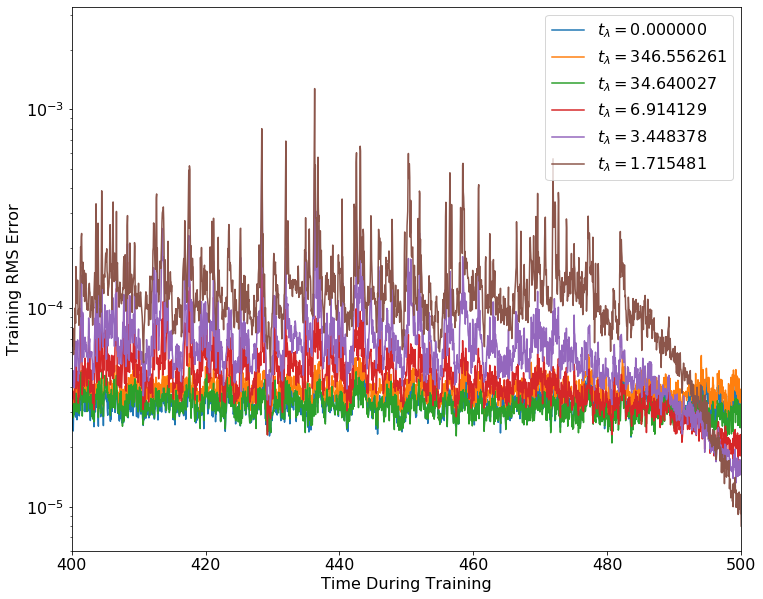

In [32]:
train_times = np.arange(step,2*250+step,step)
plt.figure(figsize = (12,10))
for k in range(num_forgets):
    valid_time_save_norm = valid_times_norm[:,:,k]
    np.savetxt('Lorenz63Data/lorenz_valid_times_norm_rperiod500_lam%f_tikreg%e.csv' % (forgets[k],regularization[k]),valid_time_save_norm,delimiter = ',')
    if forgets[k] == 1.:
        tfgt = 0.
    else:
        tfgt = step*np.log(1/2)/np.log(forgets[k])
    plt.semilogy(train_times,np.mean(train_errors_norm[:,:,k],axis = 1),label = '$t_\lambda = %f$' % tfgt)
plt.xlabel('Time During Training')
plt.ylabel('Training RMS Error')
plt.xlim(400,500)
plt.rc('font',size = 16)
plt.legend()
plt.savefig('lorenz_training_error.pdf')
plt.show()

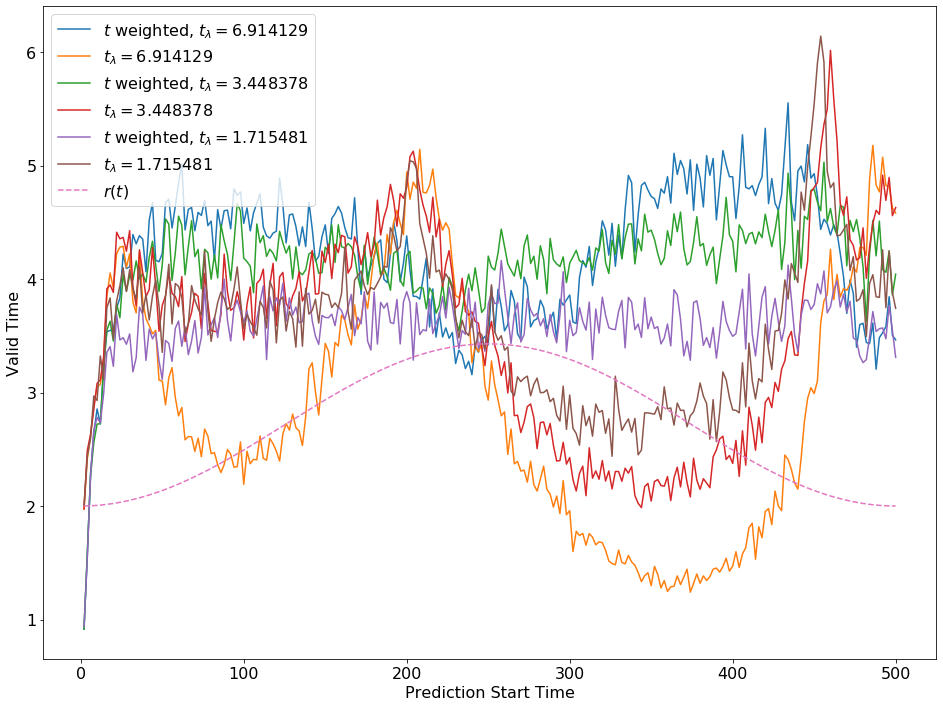

In [102]:
plt.figure(figsize=(16, 12))
for k in range(2,num_forgets):
    valid_time_save_norm = valid_times_norm_wt[:,:,k]
    np.savetxt('Lorenz63Data/lorenz_valid_times_wtweight_rperiod500_lam%f_tikreg%e.csv' % (forgets[k],regularization[k]), valid_time_save_norm, delimiter = ',')
    if forgets[k]==1.:
        tlfg = 0.
    else:
        tlfg = step*np.log(1/2)/np.log(forgets[k])
    plt.plot(times-47.95,np.mean(valid_time_save_norm[:,:],axis = 1)*step,label = '$t$ weighted, $t_\lambda = %f$' % tlfg)
    valid_time_save_norm = valid_times_norm[:,:,k]
    np.savetxt('Lorenz63Data/lorenz_valid_times_rperiod500_lam%f_tikreg%e.csv' % (forgets[k],regularization[k]), valid_time_save_norm, delimiter = ',')
    plt.plot(times-47.95,np.mean(valid_time_save_norm[:,:],axis = 1)*step,label = '$t_\lambda = %f$' % tlfg)
    
# valid_time_save_norm = np.loadtxt('Lorenz63Data/lorenz_valid_times_norm_rconst_lam%f_tikreg%e.csv' % (1.,1e-5),delimiter = ',')
# plt.plot(times-47.95,np.mean(valid_time_save_norm[:,:],axis = 1)*step,label = 'Normal')
plt.plot(times-47.95,2*r_t_cosine(times-47.95),'--',label = '$r(t)$')
plt.xlabel('Prediction Start Time')
plt.ylabel('Valid Time')
plt.legend()
plt.savefig('lorenz_valid_times_norm_wtweight_vslambda.pdf')
plt.show()

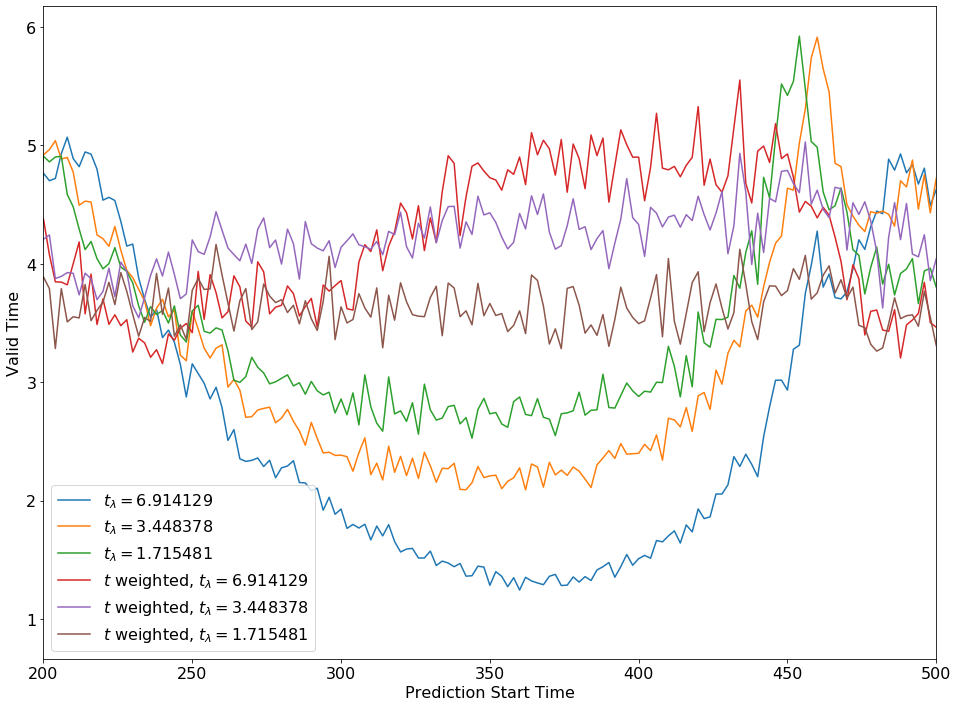

In [90]:
plt.figure(figsize=(16, 12))
plot_forgets = np.array([0.995,0.99,0.98])
plot_reg = 1e-10
times = np.arange(2.,2*250+2,2)
for k in range(len(plot_forgets)):
    valid_time_save_norm =np.loadtxt('Lorenz63Data/lorenz_valid_times_rperiod500_lam%f_reg%e_delta%e.csv' % (plot_forgets[k],plot_reg,1.),delimiter = ',')
    if plot_forgets[k]==1.:
        tlfg = 0.
    else:
        tlfg = step*np.log(1/2)/np.log(plot_forgets[k])
    plt.plot(times,np.mean(valid_time_save_norm[:,:],axis = 1)*step,label = '$t_\lambda = %f$' % tlfg)
    
for k in range(2,num_forgets):
    valid_time_save_norm = np.loadtxt('Lorenz63Data/lorenz_valid_times_wtweight_rperiod500_lam%f_tikreg%e.csv' % (forgets[k],regularization[k]), delimiter = ',')
    if forgets[k]==1.:
        tlfg = 0.
    else:
        tlfg = step*np.log(1/2)/np.log(forgets[k])
    plt.plot(times,np.mean(valid_time_save_norm[:,:],axis = 1)*step,label = '$t$ weighted, $t_\lambda = %f$' % tlfg)
# valid_time_save_norm = np.loadtxt('Lorenz63Data/lorenz_valid_times_norm_rconst_lam%f_tikreg%e.csv' % (1.,1e-5),delimiter = ',')
# plt.plot(times-47.95,np.mean(valid_time_save_norm[:,:],axis = 1)*step,label = 'Normal')
plt.xlabel('Prediction Start Time')
plt.ylabel('Valid Time')
plt.legend()
plt.savefig('lorenz_valid_times_norm_wtweight_vslambda.pdf')
plt.xlim(200,500)
plt.show()

[ 49.95  51.95  53.95  55.95  57.95  59.95  61.95  63.95  65.95  67.95
  69.95  71.95  73.95  75.95  77.95  79.95  81.95  83.95  85.95  87.95
  89.95  91.95  93.95  95.95  97.95  99.95 101.95 103.95 105.95 107.95
 109.95 111.95 113.95 115.95 117.95 119.95 121.95 123.95 125.95 127.95
 129.95 131.95 133.95 135.95 137.95 139.95 141.95 143.95 145.95 147.95
 149.95 151.95 153.95 155.95 157.95 159.95 161.95 163.95 165.95 167.95
 169.95 171.95 173.95 175.95 177.95 179.95 181.95 183.95 185.95 187.95
 189.95 191.95 193.95 195.95 197.95 199.95 201.95 203.95 205.95 207.95
 209.95 211.95 213.95 215.95 217.95 219.95 221.95 223.95 225.95 227.95
 229.95 231.95 233.95 235.95 237.95 239.95 241.95 243.95 245.95 247.95
 249.95 251.95 253.95 255.95   0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.  

In [ ]:
train_out = wout_norm @ aug_states
plt.plot(train_out[0,:1000])
plt.plot(train_input_sequence[0,transient_length:transient_length + 1000])
plt.show

In [ ]:
for i in range(num_forgets):
    valid_time_save = valid_times[:,:,i]
    np.savetxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_reg%e.csv' % (forgets[i],LM_reg),valid_time_save,delimiter = ',')

In [ ]:
for i in range(num_forgets):
    valid_times = np.savetxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_reg%e.csv' % (forgets[i],LM_reg),valid_time_save,delimiter = ',')

In [ ]:
itr = 0
run = 10
fgt = 3
fgtm = step*np.log(1/2)/np.log(forgets[fgt])
plt.plot(np.arange(predict_length)*step,truths_norm[0,:,itr,run],label = 'Truth')
plt.plot(np.arange(predict_length)*step,predictions_norm[0,:,itr,run],label = 'Reservoir')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.legend()
plt.show()

plt.plot(np.arange(predict_length)*step,truths[0,:,itr,run,fgt],label = 'Truth')
plt.plot(np.arange(predict_length)*step,predictions[0,:,itr,run,fgt],label = 'Reservoir')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.legend()
plt.show()

plt.plot(times,np.mean(valid_times_norm[:,:],axis = 1)*step,label = 'Normal')
plt.plot(times,np.mean(valid_times[:,:,fgt],axis = 1)*step,label = 'RLS, t_\lambda = %f' % fgtm)
plt.xlabel('Prediction Start Time')
plt.ylabel('Valid Time')
plt.legend()
plt.show()

In [ ]:
print(times)

In [ ]:
best_valid_times = np.zeros((3,num_predictions))
max_avg_valid_times = np.zeros(num_predictions)
for k in range(num_forgets):
    for LM_reg in LM_regs:
        new_avg_valid_times = np.zeros(num_predictions)
        for data_seed in range(num_trials):
            new_avg_valid_times = new_avg_valid_times + np.loadtxt('Lorenz63Data/lorenz_valid_times_period2000_lam%f_reg%e_seed%d.csv' % (forgets[k],LM_reg,data_seed),delimiter = ',')
        new_avg_valid_times = new_avg_valid_times/num_trials
        max_avg_valid_times = np.maximum(max_avg_valid_times,new_avg_valid_times)
        for pred in range(num_predictions):
            if max_avg_valid_times[pred] == new_avg_valid_times[pred]:
                best_valid_times[0,pred] = data_seed
                best_valid_times[1,pred] = forgets[k]
                best_valid_times[2,pred] = LM_reg

In [ ]:
# print(best_valid_times)


In [ ]:
wouts_abs = np.sqrt(np.mean((wouts - wouts_norm)**2,axis = (0,1)))
plt.plot(wouts_abs)
plt.show()

In [ ]:
itr = 47
run = 15
fg  = 7
times_all = step*(transient_length + start_length + np.arange(num_predictions)*predict_gap_length)
plt.plot(times_all,r_t_cosine(times))
plt.plot(times[itr],r_t_cosine(times[itr]),'r.')
plt.xlabel('Time')
plt.ylabel('r(t)')
plt.savefig('r_t_cosine_itr%d_run%d_forget%d.pdf' % (itr,run,fg))
plt.show()
plt.plot(np.arange(predict_length)*step,truths[0,:,itr,run,fg],label = 'Truth')
plt.plot(np.arange(predict_length)*step,predictions[0,:,itr,run,fg],label = 'Reservoir w/ RLS')
plt.xlabel('Time')
plt.ylabel('x(t)')
tlfg = step*np.log(1/2)/np.log(forgets[fg])
plt.title('$t_\lambda = %f$' % tlfg)
plt.legend()
plt.savefig('x_t_truth_vs_pred_winnergarbage_itr%d_run%d_forget%d_reg1e-8_wapproxLMreg.pdf' % (itr,run,fg))
plt.show()

In [ ]:
idx1 = 3
tl1 = step*np.log(1/2)/np.log(forgets[idx1])
idx2 = 7
tl2 = step*np.log(1/2)/np.log(forgets[idx2])
# plt.errorbar(times,np.mean(valid_times[:,:,0],axis = 1)*step,step*np.std(valid_times[:,:,0],axis = 1),label = '$t_\lambda = \infty$')
plt.errorbar(times,np.mean(valid_times[:,:,idx1],axis = 1)*step,step*np.std(valid_times[:,:,idx1],axis = 1),label = '$t_\lambda = %f$' % tl1)
plt.errorbar(times,np.mean(valid_times[:,:,idx2],axis = 1)*step,step*np.std(valid_times[:,:,idx2],axis = 1),label = '$t_\lambda = %f$' % tl2)
plt.legend()
plt.xlabel('Prediction Start Time')
plt.ylabel('Valid Time')
plt.title('T = 500, 300 Reservoir Nodes, $\mu = 10^{-8}$')
plt.savefig('valid_time_vs_start_time_winnergarbage_reg1e-8_wapproxLMreg.pdf')
plt.show()

In [ ]:
plt.plot(predictions[0,:,80,5,6])
plt.plot(truths[0,:,80,5,6])
plt.show()